# 	Use python to download the historical daily data via Yahoo Finance.



In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U matplotlib

Requirement already up-to-date: matplotlib in ./opt/anaconda3/lib/python3.8/site-packages (3.3.3)
Note: you may need to restart the kernel to use updated packages.


# Show the movement of any stock from the S&P 500 Index for the period Jan to Oct 2020. 

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl

In [4]:
initial_data = yf.download("NKE", start="2020-01-01", end="2020-11-01")

[*********************100%***********************]  1 of 1 completed


In [5]:
initial_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,101.360001,102.209999,101.019997,102.199997,101.235237,5644100
2020-01-03,100.589996,102.000000,100.309998,101.919998,100.957878,4541800
2020-01-06,100.949997,101.839996,100.870003,101.830002,100.868736,4612400
2020-01-07,101.809998,102.739998,100.809998,101.779999,100.819206,6719900
2020-01-08,101.309998,102.139999,100.849998,101.550003,100.591377,4942200


In [6]:
initial_data['Adj Close'].head()

Date
2020-01-02    101.235237
2020-01-03    100.957878
2020-01-06    100.868736
2020-01-07    100.819206
2020-01-08    100.591377
Name: Adj Close, dtype: float64

In [7]:
data = initial_data['Adj Close']

#Plot the movement (shape) of the stock over this time period and calculate its volatility.

In [8]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [9]:
rets = np.log(data / data.shift(1))
rets.head().round(4)

Date
2020-01-02       NaN
2020-01-03   -0.0027
2020-01-06   -0.0009
2020-01-07   -0.0005
2020-01-08   -0.0023
Name: Adj Close, dtype: float64

<AxesSubplot:xlabel='Date'>

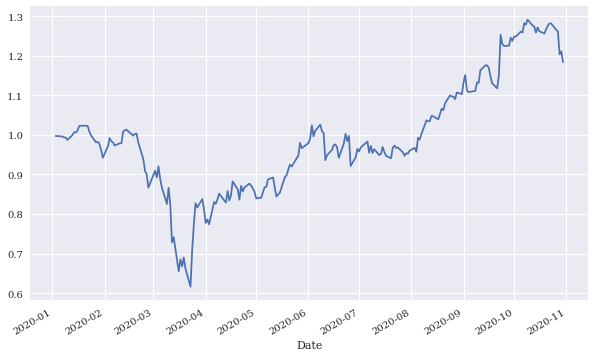

In [10]:
rets.cumsum().apply(np.exp).plot(figsize=(10, 6))

In [11]:
S = data[-1]
print('The spot price is $', round(S,2), '.')

The spot price is $ 119.84 .


In [12]:
log_return = np.log(data / data.shift(1))
vol_h = np.sqrt(252) * log_return.std()
print('The annualised volatility is', round(vol_h*100,2), '%')

The annualised volatility is 44.62 %


# Design a derivative and its associated pricing value using different methods.

# BINOMIAL TREE methods

In [13]:
import numpy as np
import os

In [14]:
S0 = 119.84         #Spot Price
K = 125             #Strike Price
T = 1.0             #Time to maturity
r = 0.0097          #Riskfree rate  
sig = 0.446         #Volatility
N = 3               #Number of time
payoff = "put"      

# Step 1 : Creation of the binomial price tree

In [15]:
dT = float(T) / N
u = np.exp(sig * np.sqrt(dT))
d = 1.0 / u        

In [16]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1

In [17]:
S

array([[119.84      , 155.03575067, 200.56812406, 259.47287779],
       [  0.        ,  92.63428298, 119.84      , 155.03575067],
       [  0.        ,   0.        ,  71.60472616,  92.63428298],
       [  0.        ,   0.        ,   0.        ,  55.3492362 ]])

In [18]:
a = np.exp(r * dT)    
p = (a - d)/ (u - d)  
q = 1.0 - p           
p

0.4421983618705394

# Step 2 : Find option value at each final node

In [19]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , 32.36571702],
       [ 0.        ,  0.        ,  0.        , 69.6507638 ]])

# Step 3 : Find option value at earlier nodes. 

In [20]:
if payoff =="call":
    for j in range(N-1, -1, -1):
        for i in range(j+1):
            V[i,j] = np.maximum(S[i,j] - K,np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1]))
elif payoff =="put":
    for j in range(N-1, -1, -1):
        for i in range(j+1):
            V[i,j] = np.maximum(K - S[i,j],np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1]))
V

array([[25.32667732, 10.005444  ,  0.        ,  0.        ],
       [ 0.        , 37.61966093, 17.99537077,  0.        ],
       [ 0.        ,  0.        , 53.39527384, 32.36571702],
       [ 0.        ,  0.        ,  0.        , 69.6507638 ]])

In [21]:
print('vanilla ' + payoff, str( V[0,0]))

vanilla put 25.3266773194824


# MONTE CARLO SIMULATION 

In [22]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [23]:
T = 1                  #Time to maturity
r = 0.0097             #Riskfree rate
sigma = 0.446          #Volatility
S0 = 119.84            #Spot Price
K = 125                #Strike Price

In [24]:
S = mcs_simulation_np(1000)

In [25]:
S = np.transpose(S)
S

array([[119.84      , 120.09647638, 120.46847668, ..., 118.58766405,
        117.5912906 , 117.42867509],
       [119.84      , 119.36390387, 118.48928541, ...,  70.87038326,
         71.94795897,  71.82443778],
       [119.84      , 117.50450339, 117.94732395, ..., 123.13937809,
        121.61989304, 121.12140077],
       ...,
       [119.84      , 120.24833308, 122.48876911, ..., 139.21588121,
        139.07031453, 136.86696761],
       [119.84      , 118.69841413, 121.09197186, ...,  62.42760354,
         62.17544195,  61.27306906],
       [119.84      , 119.43508089, 116.68060632, ...,  77.75841506,
         77.56482827,  78.01935543]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

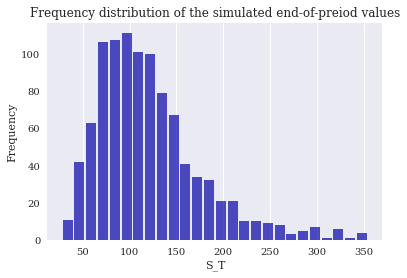

In [26]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [27]:
p = np.mean(np.maximum(K - S[:,-1],0))
print('vanilla put', str(p))

vanilla put 23.335083760146823


In [28]:
c = np.mean(np.maximum(S[:,-1] - K,0))
print('vanilla call', str(c))

vanilla call 19.565751546495807


# Analysis of the derivative using Greeks for the risk management purpose

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si

# Option Value

In [30]:
def vanilla_option(S, K, T, r, q, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #q: continuous dividend yield
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value =  - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [31]:
vanilla_option(119.84, 125, 1, 0.0097, 0.0079, 0.446, 'call')

19.05107444385863

In [32]:
vanilla_option(119.84, 125, 1, 0.0097, 0.0079, 0.446, 'put')

23.9474423218714

In [33]:
S = np.linspace(50,150,11)
Call = np.zeros((len(S),1))
Put = np.zeros((len(S),1))
for i in range(len(S)):
    Call [i] = vanilla_option(S[i],125,1,0.0097,0.0079,0.446,'call')
    Put [i] = vanilla_option(S[i],125,1,0.0097,0.0079,0.446,'put')

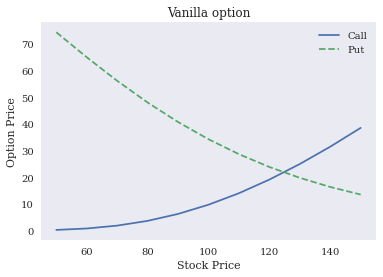

In [34]:
fig = plt.figure()
plt.plot(S, Call, '-')
plt.plot(S, Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('Vanilla option')
plt.legend(['Call','Put'])

# Greek 1 : DELTA

In [35]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [36]:
delta(119.84, 125, 1, 0.0097, 0.0079, 0.446, 'call')

0.5483623826825045

In [37]:
delta(119.84, 125, 1, 0.0097, 0.0079, 0.446, 'put')

-0.44376874030636493

In [38]:
S = np.linspace(50,150,11)
Delta_Call = np.zeros((len(S),1))
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Call [i] = delta(S[i],125, 1, 0.0097, 0.0079, 0.446, 'call')
    Delta_Put [i] = delta(S[i],125, 1, 0.0097, 0.0079, 0.446, 'put')

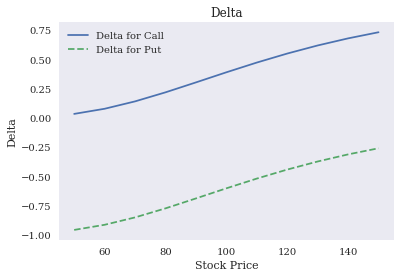

In [39]:
fig = plt.figure()
plt.plot(S, Delta_Call, '-')
plt.plot(S, Delta_Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Call','Delta for Put'])

# Greek 2 : GAMMA

In [40]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(-r * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * T)
    
    return gamma

In [41]:
gamma(119.84, 125, 1, 0.0097, 0.0079, 0.446, 'call')

0.007327360920106031

In [42]:
gamma(119.84, 125, 1, 0.0097, 0.0079, 0.446, 'put')

0.007327360920106031

In [43]:
S = np.linspace(50,150,11)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i],125, 1, 0.0097, 0.0079, 0.446, 'call')

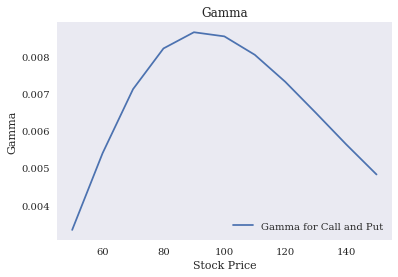

In [44]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call and Put'])

# Greek 3 : SPEED

In [45]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * T) * (d1 + vol * np.sqrt(T))
    
    return speed

In [46]:
speed(119.84, 125, 1, 0.0097, 0.0079, 0.446, 'call')

7.945247577149638e-05

In [47]:
speed(119.84, 125, 1, 0.0097, 0.0079, 0.446, 'put')

7.945247577149638e-05

In [48]:
S = np.linspace(50,150,11)
Speed = np.zeros((len(S),1))
for i in range(len(S)):
    Speed [i] = speed(S[i],125, 1, 0.0097, 0.0079, 0.446, 'call')

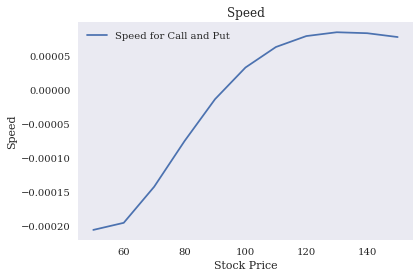

In [49]:
fig = plt.figure()
plt.plot(S, Speed, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Call and Put'])

# Greek 4 : Theta

In [50]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [51]:
theta(119.84, 125, 1, 0.0097, 0.0079, 0.446, 'call')

10.418594362882986

In [52]:
theta(119.84, 125, 1, 0.0097, 0.0079, 0.446, 'put')

10.813117871726325

In [53]:
T = np.linspace(0.25,3,12)
Theta_Call = np.zeros((len(T),1))
Theta_Put = np.zeros((len(T),1))
for i in range(len(T)):
    Theta_Call [i] = theta(119.84, 125, T[i], 0.0097, 0.0079, 0.446, 'call')
    Theta_Put [i] = theta(119.84, 125, T[i], 0.0097, 0.0079, 0.446, 'put')

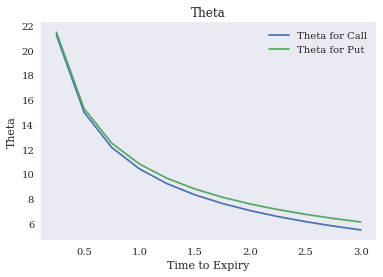

In [54]:
fig = plt.figure()
plt.plot(T, Theta_Call, '-')
plt.plot(T, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Call', 'Theta for Put'])

# Greek 5 : RHO

In [55]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [56]:
rho(119.84, 125, 1, 0.0097, 0.0079, 0.446, 'call')

46.6646734968127

In [57]:
rho(119.84, 125, 1, 0.0097, 0.0079, 0.446, 'put')

-77.12868816018617

In [59]:
r = np.linspace(0,0.1,11)
Rho_Call = np.zeros((len(r),1))
Rho_Put = np.zeros((len(r),1))
for i in range(len(r)):
    Rho_Call [i] = rho(119.84, 125, 1, r[i], 0.0079, 0.446, 'call')
    Rho_Put [i] = rho(119.84, 125, 1, r[i], 0.0079, 0.446, 'put')

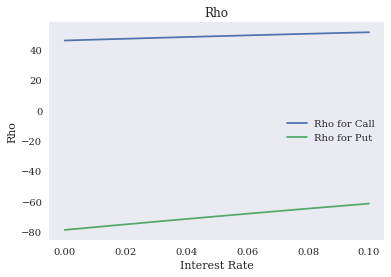

In [60]:
fig = plt.figure()
plt.plot(r, Rho_Call, '-')
plt.plot(r, Rho_Put, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend(['Rho for Call', 'Rho for Put'])